### Team Members
Hoang Nguyen (hhn1)

Vicent Dao (vdao)

Anees Akram (aneesudd)

In [14]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [15]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from IPython.core.display import display, HTML

def scrape_table(table):
    df = pd.read_html(str(table))
    df = pd.DataFrame(df[0])
    return Table.from_df(df)


# 1. Scrape data

In [16]:
egg_price_url = "https://www.globalproductprices.com/rankings/egg_prices/"
tax_rate_url = "https://tradingeconomics.com/country-list/sales-tax-rate"
currency_url = "https://taxsummaries.pwc.com/glossary/currency-codes"

In [17]:
#Scrape data from egg_price_url
egg_price_request = requests.get(egg_price_url)
egg_soup = BeautifulSoup(egg_price_request.text, 'html.parser')

raw_price_table = egg_soup.find('table')
egg_price_table = scrape_table(raw_price_table)
egg_price_table = egg_price_table.sort("Countries")
egg_price_table

<ipython-input-15-6424c7166e10>:7: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))


Countries,"Eggs prices, dozen",Rank
Argentina,3.48,25
Australia,5.08,5
Austria,3.81,17
Azerbaijan,1.59,76
Bangladesh,1.26,79
Belgium,4.12,10
Bolivia,1.87,70
Brazil,2.18,57
Bulgaria,4.87,6
Cameroon,1.94,67


In [18]:
#Scrape data from tax_rate_url
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}
tax_rate_request = requests.get(tax_rate_url, headers=headers)
tax_soup = BeautifulSoup(tax_rate_request.text, 'html.parser')

raw_tax_table = tax_soup.find('table')
tax_price_table = scrape_table(raw_tax_table)
tax_price_table

<ipython-input-15-6424c7166e10>:7: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))


Country,Last,Previous,Reference,Unit
Afghanistan,10,10,Dec/24,%
Albania,20,20,Dec/24,%
Algeria,19,19,Dec/24,%
Andorra,4.5,4.5,Dec/24,%
Angola,14,14,Dec/23,%
Antigua And Barbuda,15,15,Dec/24,%
Argentina,21,21,Dec/24,%
Armenia,20,20,Dec/24,%
Aruba,4,4,Dec/24,%
Australia,10,10,Dec/24,%


In [19]:
#Collect currency data
currency_request = requests.get(currency_url, headers=headers)
currency_soup = BeautifulSoup(currency_request.text, 'html.parser')

raw_currency_table = currency_soup.find('table')
currency_df = pd.read_html(str(raw_currency_table), header=0)[0]
currency_table = Table.from_df(currency_df)
currency_table

<ipython-input-19-9a075f66d1e2>:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  currency_df = pd.read_html(str(raw_currency_table), header=0)[0]


Territory,Currency code (ISO 4217),Currency name
Albania,ALL,lek
Algeria,DZD,dinar
Angola,AOA,kwanza
Argentina,ARS,peso
Armenia,AMD,dram
Australia,AUD,dollar
Austria,EUR,euro
Azerbaijan,AZN,manat
Bahrain,BHD,dinar
Barbados,BBD,dollar


# 2. Data Cleaning

In [20]:
missing_country_mapping = {
    "United States" : "USA",
    "United Kingdom" : "UK",
    "Dominican Republic" : 'Domin. Rep.',
    "United Arab Emirates": "UA Emirates",
    "Czech Republic" : "Czechia"

}

tax_price_table = tax_price_table.with_columns("Country",[missing_country_mapping.get(x, x) for x in tax_price_table.column("Country")])
tax_price_table

Country,Last,Previous,Reference,Unit
Afghanistan,10,10,Dec/24,%
Albania,20,20,Dec/24,%
Algeria,19,19,Dec/24,%
Andorra,4.5,4.5,Dec/24,%
Angola,14,14,Dec/23,%
Antigua And Barbuda,15,15,Dec/24,%
Argentina,21,21,Dec/24,%
Armenia,20,20,Dec/24,%
Aruba,4,4,Dec/24,%
Australia,10,10,Dec/24,%


In [21]:
# Importing rapidfuzz for string matching
!pip install rapidfuzz
from rapidfuzz import process, fuzz

# Combine all unique country names
all_countries = set(egg_price_table.column('Countries')).union(
    set(tax_price_table.column('Country')), set(currency_table.column('Territory'))
)

# Empty mapping dict and threshold for matching score
mapping = {}
threshold = 80

# Perform fuzzy matching to standardize country names
all_countries = list(all_countries)  # Convert to a list for iteration
for country in all_countries:
    match = process.extractOne(country, all_countries, scorer=fuzz.token_sort_ratio)
    if match and match[1] >= threshold:
        # High-confidence match
        mapping[country] = match[0]
    else:
        # No match or low confidence, retain original value
        mapping[country] = country

# Standardize each table using the mapping
def standardize_country(name):
    return mapping.get(name, name)

egg_price_table = egg_price_table.with_column('Standardized_Country', egg_price_table.apply(standardize_country, 'Countries'))
tax_price_table = tax_price_table.with_column('Standardized_Country', tax_price_table.apply(standardize_country, 'Country'))
currency_table = currency_table.with_column('Standardized_Country', currency_table.apply(standardize_country, 'Territory'))

print("Mapping:", mapping)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 25.5 MB/s eta 0:00:00
Mapping: {'Burkina Faso': 'Burkina Faso', 'Lesotho': 'Lesotho', 'Montenegro': 'Montenegro', 'Laos': 'Laos', 'Uzbekistan': 'Uzbekistan', 'Vietnam': 'Vietnam', 'Morocco': 'Morocco', 'Oman': 'Oman', 'Congo, Republic of': 'Congo, Republic of', 'Samoa': 'Samoa', 'Guyana': 'Guyana', 'Lithuania': 'Lithuania', 'Comoros': 'Comoros', 'Tanzania': 'Tanzania', 'Dominican Republic': 'Dominican Republic', 'Belarus': 'Belarus', 'Malawi': 'Malawi', 'Sierra Leone': 'Sierra Leone', 'Iran': 'Iran', 'Euro Area': 'Euro Area', 'Chile': 'Chile', 'Papua New Guinea': 'Papua New Guinea', 'Myanmar': 'Myanmar', 'Gabon': 'Gabon', 'North Macedonia': 'North Macedonia', 'Dominica': 'Dominica', 'Puerto Rico': 'Puerto Rico', 'United States': 'United States', 'Austria': 'Austria', 'Philippines': 'Philippines', 'Saudi Arabia': 'Saudi Arabia', 'Grenada': 'Grenada', 'Namibia': 'Namibia', 'Colombia': 'Colombia', 'Guam': 'Guam', 'North Korea': 'North

In [22]:
# Cleaning and formatting egg prices table
egg_price_table = egg_price_table.drop(['Countries', 'Rank'])
egg_price_table = egg_price_table.relabeled('Standardized_Country', 'Country')
egg_price_table = egg_price_table.relabeled('Eggs prices, dozen', 'Eggs price (USD)')

egg_price_table

Eggs price (USD),Country
3.48,Argentina
5.08,Australia
3.81,Austria
1.59,Azerbaijan
1.26,Bangladesh
4.12,Belgium
1.87,Bolivia
2.18,Brazil
4.87,Bulgaria
1.94,Cameroon


In [23]:
# Cleaning and formatting tax prices table
tax_price_table = tax_price_table.drop(['Country', 'Previous', 'Reference', 'Unit'])
tax_price_table = tax_price_table.relabeled('Standardized_Country', 'Country')
tax_price_table = tax_price_table.relabeled('Last', 'Tax  Rate (%)')

tax_price_table

Tax Rate (%),Country
10,Afghanistan
20,Albania
19,Algeria
4.5,Andorra
14,Angola
15,Antigua And Barbuda
21,Argentina
20,Armenia
4,Aruba
10,Australia


In [24]:
# Cleaning and formatting currencies table
currency_table = currency_table.drop(['Territory', 'Currency name'])
currency_table = currency_table.relabeled('Currency code (ISO 4217)', 'Currency')
currency_table = currency_table.relabeled('Standardized_Country', 'Country')

currency_table

Currency,Country
ALL,Albania
DZD,Algeria
AOA,Angola
ARS,Argentina
AMD,Armenia
AUD,Australia
EUR,Austria
AZN,Azerbaijan
BHD,Bahrain
BBD,Barbados


In [25]:
# Merging final tables for vizualization
data_merged = egg_price_table.join("Country", tax_price_table)
data = data_merged.join("Country", currency_table)

data.show(5)

Country,Eggs price (USD),Tax Rate (%),Currency
Argentina,3.48,21,ARS
Australia,5.08,10,AUD
Austria,3.81,20,EUR
Azerbaijan,1.59,18,AZN
Belgium,4.12,21,EUR


In [26]:
egg_price_cad = 2.79 # Price extracted from egg prices url

data = data.with_columns('Difference', data.column("Eggs price (USD)") - egg_price_cad)

data.show(5)

Country,Eggs price (USD),Tax Rate (%),Currency,Difference
Argentina,3.48,21,ARS,0.69
Australia,5.08,10,AUD,2.29
Austria,3.81,20,EUR,1.02
Azerbaijan,1.59,18,AZN,-1.2
Belgium,4.12,21,EUR,1.33


<h1>3. VISUALIZATION<h1>

**External Factor**

In [93]:
#Cleaning Electricity Data
electricity_url = 'https://raw.githubusercontent.com/hoangr1010/CMPUT-191---A3/refs/heads/main/data/cost-of-electricity-by-country-2024.csv'
electricity_data = Table.read_table(electricity_url)
electricity_data = electricity_data.drop("CostOfElectricity_ElectricityCost_USDPerkWh_2023March", "CostOfElectricity_ElectricityCost_USDPerkWh_2022Sept")
electricity_data = electricity_data.relabeled("CostOfElectricity_ElectricityCost_USDPerkWh_2024March", "Electricity Cost (USD/kWh) - 03/2024")
electricity_data = electricity_data.relabeled("country", "Country")
electricity_data.where('Country', are.equal_to('Canada'))
# Canadian Electricity Cost is 0.126


Country,Electricity Cost (USD/kWh) - 03/2024
Canada,0.126


In [94]:
#Filter countries in data
electricity_data = electricity_data.where('Country', are.contained_in(data.column('Country'))).sort("Country")
data = data.where('Country', are.not_equal_to('Canada'))
data_countries = np.unique(data.column('Country'))
electricity_countries = np.unique(electricity_data.column('Country'))
missing_countries = np.setdiff1d(data_countries, electricity_countries)
data = data.where('Country', are.not_contained_in(missing_countries))
electricity_data.show(5)

Country,Electricity Cost (USD/kWh) - 03/2024
Argentina,0.02
Australia,0.273
Austria,0.36
Azerbaijan,0.047
Belgium,0.365


In [96]:
#Add electric cost difference column to data
data = data.with_column('Electric Cost Difference (USD/KWH)', electricity_data.column("Electricity Cost (USD/kWh) - 03/2024") - 0.126)
data.show()

Country,Eggs price (USD),Tax Rate (%),Currency,Difference,Difference(untaxed),Electric Cost Difference (USD/KWH)
Argentina,3.48,21,ARS,0.69,0.57,-0.106
Australia,5.08,10,AUD,2.29,2.08,0.147
Austria,3.81,20,EUR,1.02,0.85,0.234
Azerbaijan,1.59,18,AZN,-1.2,-1.02,-0.079
Belgium,4.12,21,EUR,1.33,1.1,0.239
Brazil,2.18,17,BRL,-0.61,-0.52,0.028
Bulgaria,4.87,20,BGN,2.08,1.73,0.021
Chile,3.62,19,CLP,0.83,0.7,0.048
Colombia,2.47,19,COP,-0.32,-0.27,0.085
Costa Rica,2.6,13,CRC,-0.19,-0.17,0.049


**Visualize**

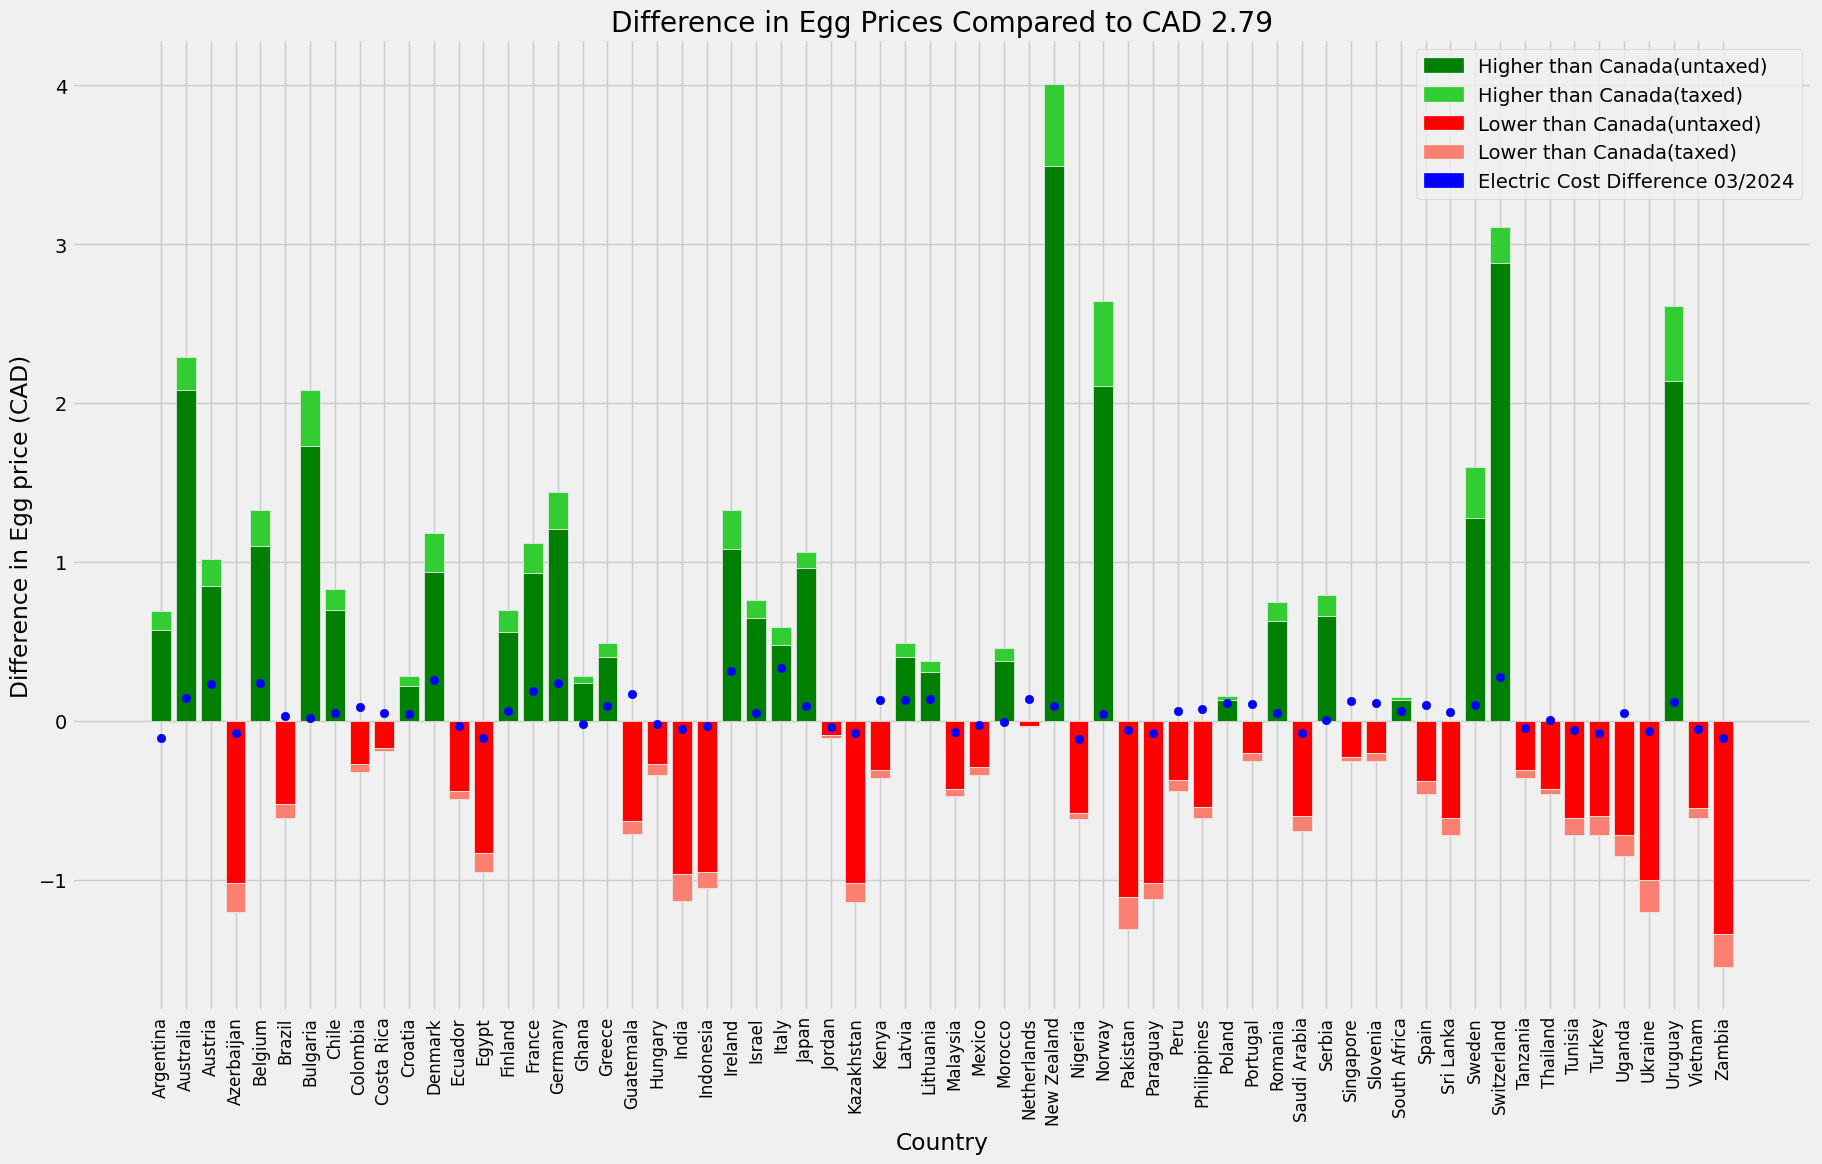

In [101]:
import matplotlib.pyplot as plt

data = data.with_column("Difference(untaxed)", (data.column("Difference") / (1 + data.column("Tax  Rate (%)")/100)).round(2))
countries = data.column('Country')
num_countries = len(countries)

# Adjust figure size
plt.figure(figsize=(20, 12))  # Width = 16, Height = 8

# Create a list of colors for each country
colors1 = ['red' if diff < 0 else 'green' for diff in data.column('Difference(untaxed)')]
colors2 = ['salmon' if diff < 0 else 'limegreen' for diff in data.column('Difference')]
# Create the bar chart with custom colors
bars1 = plt.bar(countries, data.column('Difference(untaxed)'), color=colors1)
bars2 = plt.bar(countries, data.column('Difference') - data.column("Difference(untaxed)"), bottom=data.column('Difference(untaxed)'), color= colors2)

# Create the scatter plot
plt.scatter(countries, data.column("Electric Cost Difference (USD/KWH)"), marker='o', color='blue')

# Set x-axis labels and rotate them for better readability
plt.xticks(ticks=range(len(countries)), labels=countries, rotation=90, ha='center', fontsize=12)

# Add labels and title
plt.xlabel('Country')
plt.ylabel('Difference in Egg price (CAD)')
plt.title('Difference in Egg Prices Compared to CAD 2.79')


# Create proxy artists for the legend (red and green rectangles)
green_patch = plt.Rectangle((0, 0), 1, 1, color='green')
lime_patch = plt.Rectangle((0, 0), 1, 1, color='limegreen')
red_patch = plt.Rectangle((0, 0), 1, 1, color='red')
salmon_patch = plt.Rectangle((0, 0), 1, 1, color='salmon')
blue_patch = plt.Rectangle((0, 0), 1, 1, color='blue')


# Add the legend using the proxy artists and labels
plt.legend([green_patch,lime_patch,red_patch,salmon_patch,blue_patch], ['Higher than Canada(untaxed)','Higher than Canada(taxed)','Lower than Canada(untaxed)','Lower than Canada(taxed)', "Electric Cost Difference 03/2024"])
# Display the chart
plt.show()